In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot

### Example file paths to saved level6 data:

In [2]:
####### AMEND THESE TO CHOSEN DATA OR CAN CHANGE PATHS TO LOCAL FILES IF RUNNING LOCALLY ######
filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
counts_file = filestem + 'Nscan966_Npix_count_cube_p0.3d_sigma3.0_iter2.fits'

### Read-in maps and coordinates:

In [3]:
MKmap,w,W,counts,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,counts_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff)
Pmod = cosmo.GetModelPk(zeff)
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
OmegaHI = 1.333333e-3
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap,w,W,counts = Init.FilterIncompleteLoS(MKmap,w,W,counts)

### Trim map edges (can fine-tune boarders if needed):
MKmap,w,W,counts = Init.MapTrim(MKmap,w,W,counts,ra,dec,ramin=334,ramax=357,decmin=-35,decmax=-26.5)

### Plot maps and spectra:

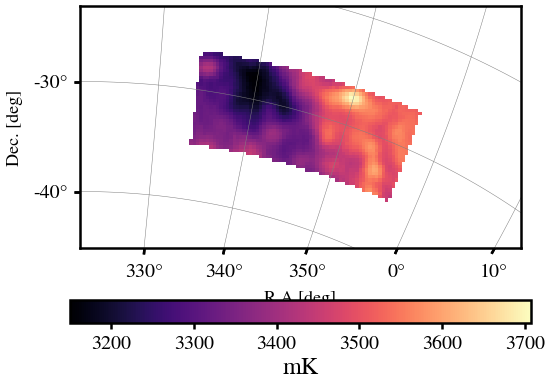

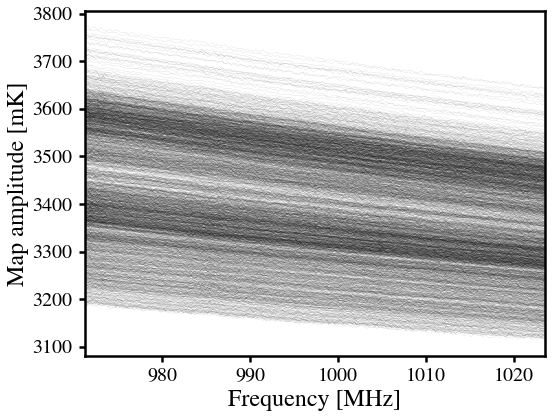

<Figure size 576x432 with 0 Axes>

In [4]:
plot.Map(MKmap,W=W,map_ra=ra,map_dec=dec,wproj=wproj)
plot.LoSspectra(MKmap,W=W,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### Examine PCA eigenmodes and covariance matrix:

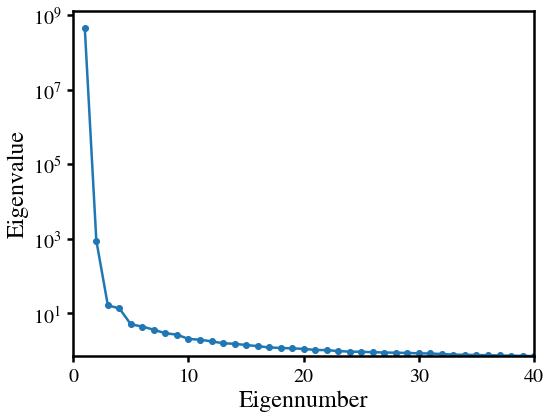

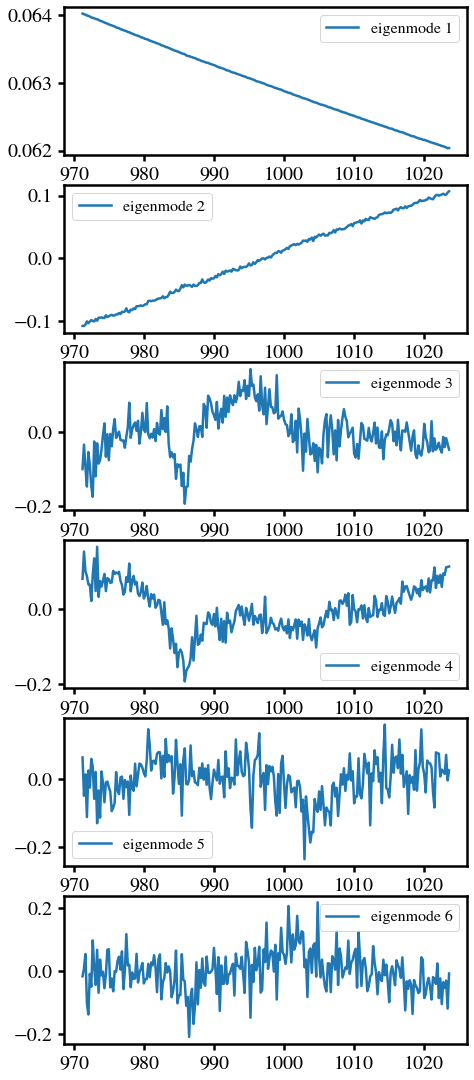

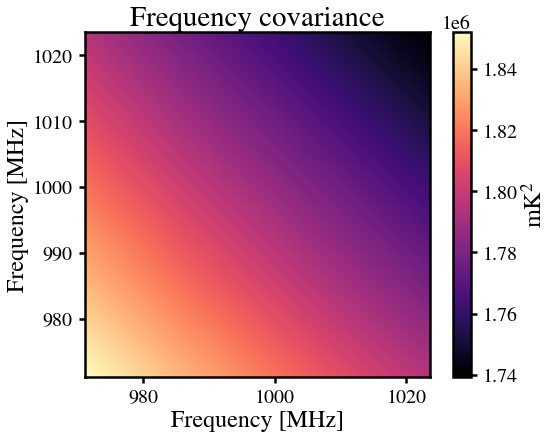

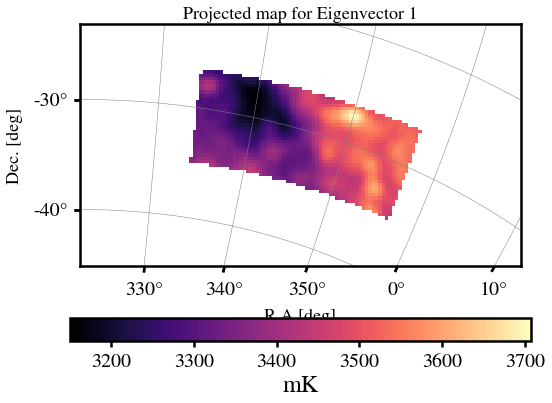

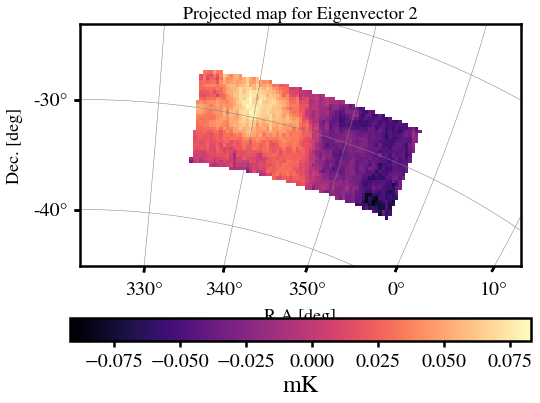

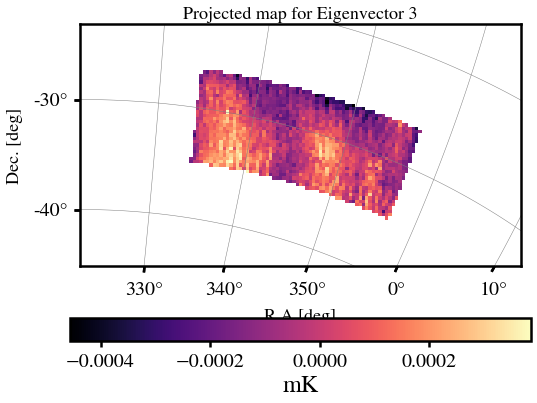

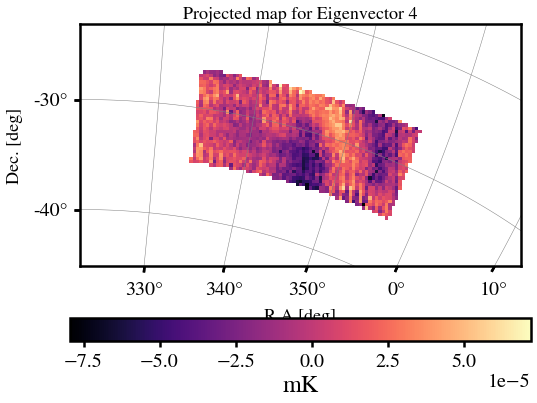

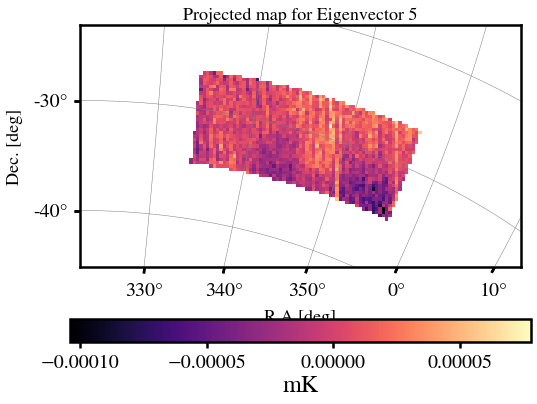

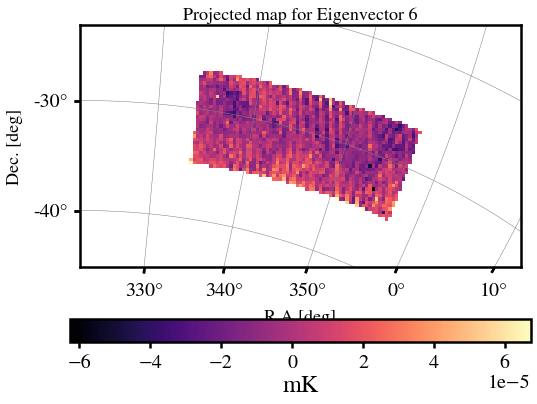

In [5]:
import foreground
C,eignumb,eigenval,V = foreground.PCAclean(MKmap,N_fg=1,W=W,w=None,returnAnalysis=True)
plot.EigenSpectrum(eignumb,eigenval)
plot.Eigenmodes(nu,V)
plot.FrequencyCovariance(C,nu)
plot.ProjectedEigenmodeMaps(MKmap,W,V,ra,dec,wproj)
plt.show()

### Plot foreground cleaned maps:

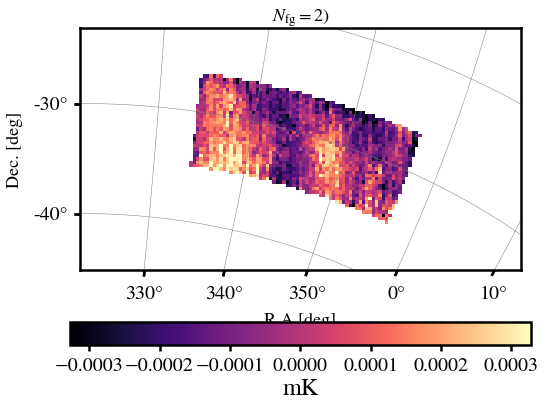

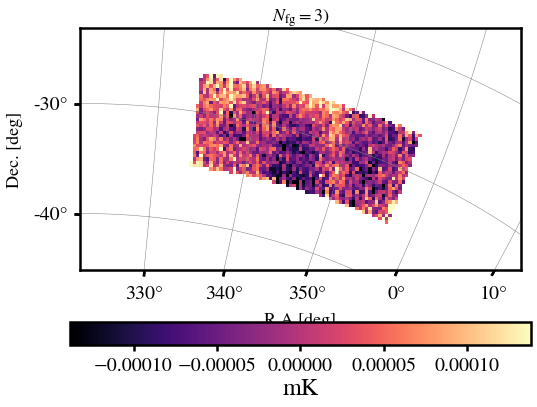

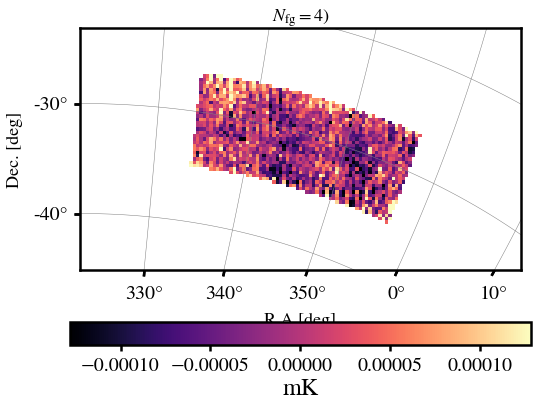

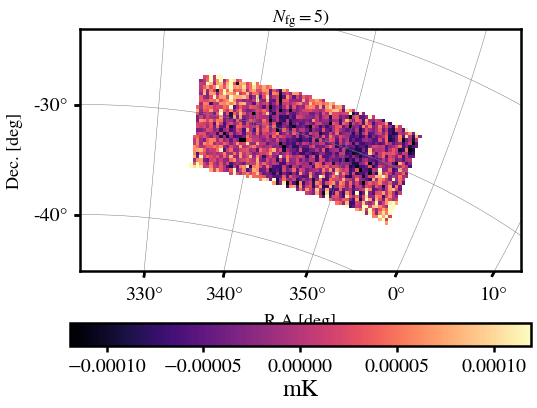

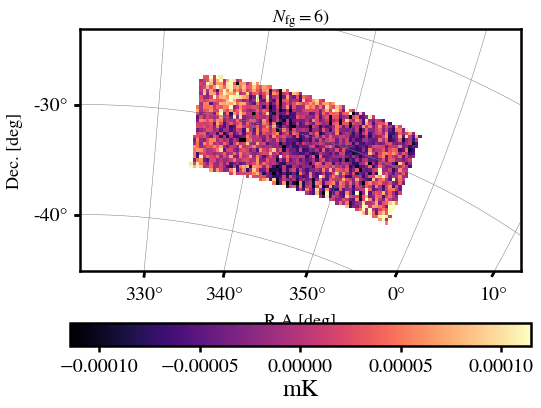

In [6]:
N_fgs = [2,3,4,5,6]
for i in range(len(N_fgs)):
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W,w=None)
    mapcut = 5*np.std(np.mean(MKmap_clean,2))
    mapcut = np.max(mapcut)
    plot.Map(MKmap_clean,map_ra=ra,map_dec=dec,wproj=wproj,W=W,title=r'$N_{\rm fg}=%s)$'%N_fgs[i],vmin=-mapcut,vmax=mapcut)
plt.show()

### Power spectrum measurement and modelling:

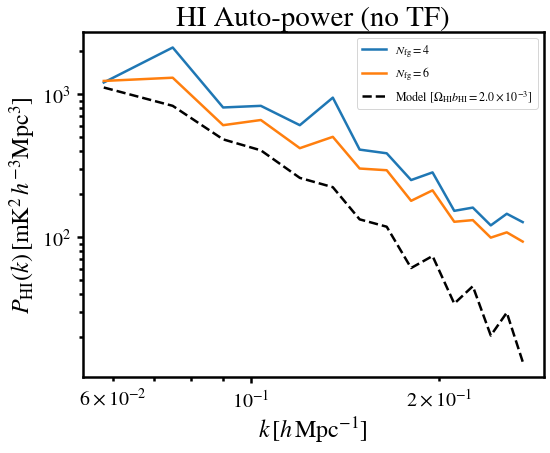

In [7]:
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]

doBlackman = False # Blackman window function to apply to maps and weights to taper edges along z direction
if doBlackman==True: blackman = np.reshape( np.tile(np.blackman(nz), (nx,ny)) , (nx,ny,nz) ) # Blackman function along every LoS
else: blackman = 1

import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
nx,ny,nz = np.shape(MKmap)
nx_rg,ny_rg,nz_rg = int(nx/2),int(ny/2),int(nz/2) # number of pixels in Comoving space to grid to
ndim = nx_rg,ny_rg,nz_rg

N_fgs = [4,6]
for i in range(len(N_fgs)):
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W,w=None)
    MKmap_clean_rg,dims,dims0 = grid.comoving(blackman*MKmap_clean,ra,dec,nu,W=W,ndim=ndim)
    w_rg,dims,dims0 = grid.comoving(blackman*w,ra,dec,nu,W=W,ndim=ndim)
    W_rg,dims,dims0 = grid.comoving(blackman*W,ra,dec,nu,W=W,ndim=ndim)
    lx,ly,lz,nx_rg,ny_rg,nz_rg = dims
    # Measure and plot power spectrum:
    Pk,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims,kbins,corrtype='HIauto',w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg)
    plt.plot(k,Pk,label=r'$N_{\rm fg}=%s$'%N_fgs[i])
pkmod,k = model.PkMod(Pmod,dims,kbins,b_HI,b_HI,f,sig_v,Tbar1=Tbar,Tbar2=Tbar,r=1,R_beam1=R_beam,R_beam2=R_beam,w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.loglog()
plt.legend(fontsize=12,loc='upper right')
plt.title('HI Auto-power (no TF)')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()

### Plot regridded maps in comoving space:

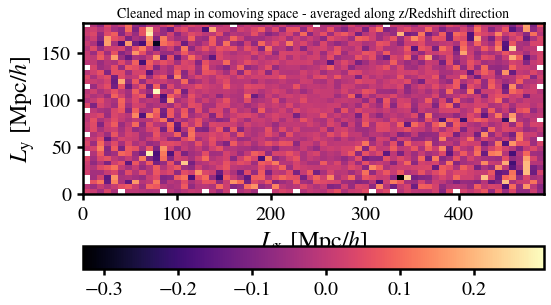

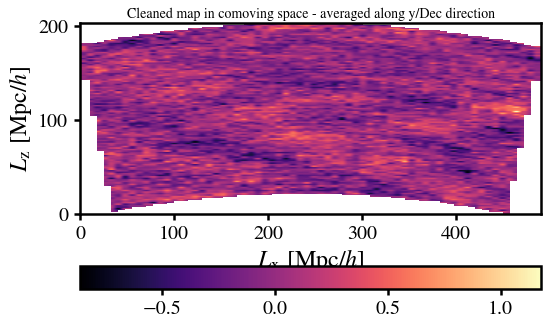

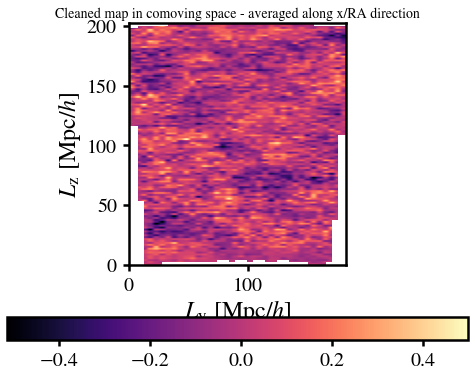

In [8]:
map_nan = np.mean(MKmap_clean_rg,2).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,lx,0,ly])
plt.xlabel(r'$L_{\rm x}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm y}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal')
plt.title('Cleaned map in comoving space - averaged along z/Redshift direction',fontsize=14)
plt.figure()
map_nan = np.mean(MKmap_clean_rg,1).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,lx,0,lz])
plt.xlabel(r'$L_{\rm x}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm z}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal')
plt.title('Cleaned map in comoving space - averaged along y/Dec direction',fontsize=14)
plt.figure()
map_nan = np.mean(MKmap_clean_rg,0).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,ly,0,lz])
plt.xlabel(r'$L_{\rm y}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm z}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal')
plt.title('Cleaned map in comoving space - averaged along x/RA direction',fontsize=14)
plt.show()

### 2D Power:

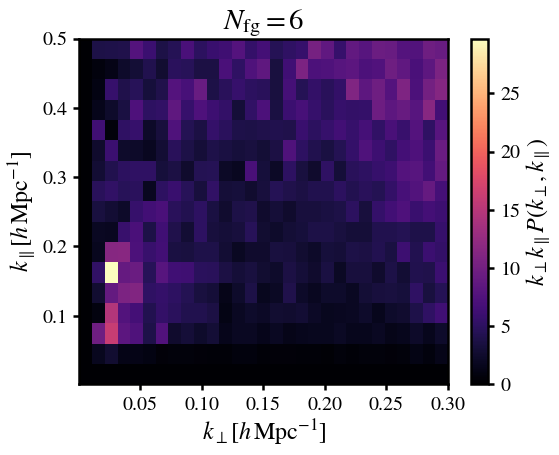

In [9]:
kperpbins = np.linspace(0.001,0.3,30)
kparabins = np.linspace(0.001,0.5,18)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kgrid = kperpcen * kparacen[:,np.newaxis]
Pk2D,nmodes = power.Pk2D(MKmap_clean_rg,MKmap_clean_rg,dims,kperpbins,kparabins,w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg)
vmax = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'$N_{\rm fg}=%s$'%N_fgs[-1])
plt.show()